## IMPORTING LIBRARIES

In [11]:
import pandas as pd
import numpy as np
import re
import emoji
import unicodedata
import nltk
import lightgbm as lgb
import optuna
import pickle

from nltk.corpus import stopwords, opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from matplotlib import pyplot as plt
import seaborn as sns

## LOADING DATASET

In [12]:
df = pd.read_csv('balanced_reviews.csv')
df.head()

,Review,Rating
0,"""Great experience.""",5.0
1,"""Had a very good time working with my teammate...",4.0
2,"""I worked for Accenture since 2007 and is an e...",4.0
3,"""I have worked for Dillard's for 20 months. It...",5.0
4,"""GPP Goodrich People Philosophy which was a cu...",4.5


In [13]:
df.shape

(8877, 2)

## CLEANING AND PREPROCESSING 

### IMPORTANT STOP WORDS THAT NEEDS TO BE KEPT FOR CONTEXT UNDERSTANDING

In [14]:
important_words = {
    'not', 'no', 'never', 'none', 'neither', 'nor', 'hardly', 'barely', 'scarcely',
    'but', 'however', 'although', 'though', 'yet', 'still', 'whereas', 'nonetheless', 'nevertheless', 'on the other hand', 'conversely', 'in contrast',
    'despite', 'in spite of', 'even though', 'even if', 'notwithstanding',
    'if', 'unless', 'provided', 'except', 'otherwise',
    'only', 'just', 'merely', 'almost', 'nearly', 'barely', 'solely'
}


### FUNCTION TO PREPROCESS REVIEW

In [15]:
def preprocess_text(sen):
    sentence = unicodedata.normalize('NFKD', sen)
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words - important_words
    words = sentence.split()
    filtered_words = [word for word in words if word not in stop_words]
    sentence = ' '.join(filtered_words)
    sentence = emoji.replace_emoji(sentence, replace='')
    return sentence

df.Review = df.Review.apply(preprocess_text)
df.Review = df.Review.apply(word_tokenize)

### FUNCTION FOR LEMMATIZATION

In [16]:
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
    return tag_dict.get(tag, wn.NOUN)

def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(word)) for word in tokens]
    return lemmas

df.Review = df.Review.apply(lemmatize_text)

### FUNCTION FOR CATEGORIZING RATINGS INTO SENTIMENTS

In [17]:
def categorize_rating(rating):
    if rating >= 4:
        return 2  #Positive
    elif rating <= 2:
        return 0  #Negative
    else:
        return 1  #Neutral
    
df['Sentiment'] = df['Rating'].apply(categorize_rating)

## VISUALIZATION 

### GETTING SENTIMENT DISTRIBUTION

C:\Users\HP\AppData\Local\Temp\ipykernel_16884\498666800.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='Set2')


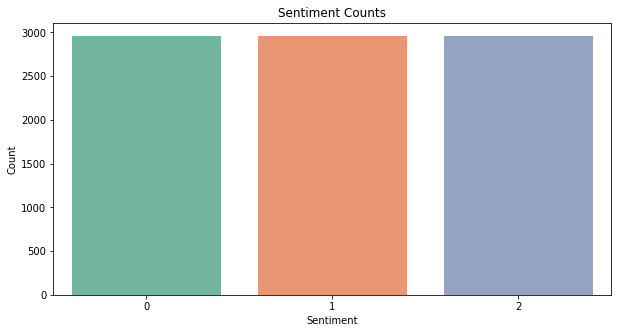

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=df, palette='Set2')
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### GETTING RATING DISTRIBUTION

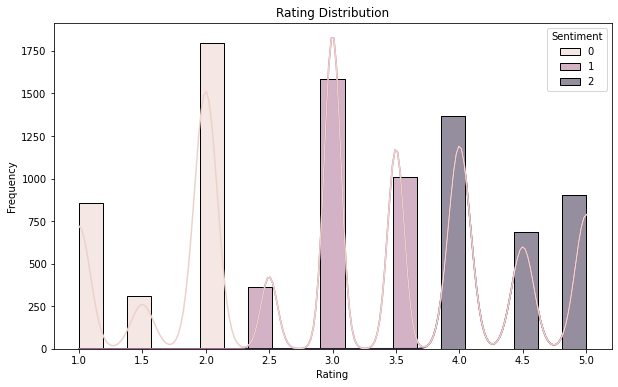

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Rating', hue='Sentiment', multiple='stack', kde=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

## EXTRACTING ADDITIONAL FEATURES 

In [20]:
df.Review = df.Review.apply(lambda x: ' '.join(x))
df['Review_Length'] = df['Review'].apply(len)

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

df['Positive_Word_Count'] = df['Review'].apply(lambda x: len([word for word in x.split() if word in positive_words]))
df['Negative_Word_Count'] = df['Review'].apply(lambda x: len([word for word in x.split() if word in negative_words]))

In [21]:
df.head(10)

,Review,Rating,Sentiment,Review_Length,Positive_Word_Count,Negative_Word_Count
0,great experience,5.0,2,16,1,0
1,good time work teammate manager,4.0,2,31,2,0
2,work accenture since excellent place work,4.0,2,41,3,0
3,work dillard month high end department store v...,5.0,2,178,4,0
4,gpp goodrich people philosophy culture instill...,4.5,2,62,0,0
5,deloitte large consult organization regularly ...,4.0,2,428,8,2
6,good agency great work,4.0,2,22,3,0
7,work dupont contract great experience learn co...,5.0,2,126,3,0
8,hertz good company work,5.0,2,23,2,0
9,company provide good environment work excellen...,4.5,2,95,4,0


## MODEL TRAINING 

### TOKENIZATION AND SEQUENCING

In [22]:
df = shuffle(df, random_state = 42)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])

### PADDING SEQUENCES

In [23]:
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [24]:
X_additional = df[['Positive_Word_Count', 'Negative_Word_Count', 'Review_Length']].values
X_combined = np.hstack((padded_sequences, X_additional))
y = df['Sentiment']

### SPLITTING TO TRAINING AND TESTING DATASETS

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

### HYPERPARAMETER TUNING USING OPTUNA 

In [19]:
def optimize_lgbm(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }
    lgbm = lgb.LGBMClassifier(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    preds = lgbm.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    return accuracy

In [20]:
def search_best_parameters(X, y, n_trials=50):
    global X_train, X_valid, y_train, y_valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    study = optuna.create_study(direction='maximize')
    study.optimize(optimize_lgbm, n_trials=n_trials)
    best_params = study.best_params
    best_accuracy = study.best_value
    print("Best parameters are:", best_params)
    print("Best accuracy is:", best_accuracy)
    return best_params, best_accuracy

In [21]:
search_best_parameters(X_combined, y)

[I 2024-11-25 16:22:08,584] A new study created in memory with name: no-name-ce77ce20-11bd-4682-b3c3-8ff7b5fb2956


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.818144349829719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.818144349829719
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.720877269508039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720877269508039
[LightGBM] [Warning] lambda_l2 is set=2.9950129826231753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9950129826231753
[LightGBM] [Warning] bagging_fraction is set=0.9825816277228858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825816277228858
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current val

[I 2024-11-25 16:22:09,767] Trial 0 finished with value: 0.6734234234234234 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.010190435090945001, 'num_leaves': 49, 'max_depth': 10, 'min_data_in_leaf': 55, 'lambda_l1': 2.720877269508039, 'lambda_l2': 2.9950129826231753, 'feature_fraction': 0.818144349829719, 'bagging_fraction': 0.9825816277228858, 'bagging_freq': 2}. Best is trial 0 with value: 0.6734234234234234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.818144349829719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.818144349829719
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.720877269508039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720877269508039
[LightGBM] [Warning] lambda_l2 is set=2.9950129826231753, reg_lambda=0.0 will be ignored. Current value: lambda_

[I 2024-11-25 16:22:11,032] Trial 1 finished with value: 0.7308558558558559 and parameters: {'boosting': 'dart', 'learning_rate': 0.22967721756567397, 'num_leaves': 125, 'max_depth': 13, 'min_data_in_leaf': 58, 'lambda_l1': 4.9621061557509885, 'lambda_l2': 2.217523555371524, 'feature_fraction': 0.9890754975652973, 'bagging_fraction': 0.6911404896611681, 'bagging_freq': 6}. Best is trial 1 with value: 0.7308558558558559.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.9890754975652973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9890754975652973
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warn

[I 2024-11-25 16:22:12,232] Trial 2 finished with value: 0.7038288288288288 and parameters: {'boosting': 'dart', 'learning_rate': 0.11638674060675466, 'num_leaves': 147, 'max_depth': 7, 'min_data_in_leaf': 20, 'lambda_l1': 5.977446155713818, 'lambda_l2': 5.895400117939512, 'feature_fraction': 0.7037012047942226, 'bagging_fraction': 0.7336857495186647, 'bagging_freq': 1}. Best is trial 1 with value: 0.7308558558558559.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-25 16:22:13,520] Trial 3 finished with value: 0.6931306306306306 and parameters: {'boosting': 'dart', 'learning_rate': 0.11372290154215565, 'num_leaves': 24, 'max_depth': 11, 'min_data_in_leaf': 77, 'lambda_l1': 0.9652404253972746, 'lambda_l2': 2.0595961150338646, 'feature_fraction': 0.7906523017208267, 'bagging_fraction': 0.7399176492383306, 'bagging_freq': 7}. Best is trial 1 with value: 0.7308558558558559.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.7906523017208267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906523017208267
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=0.9652404253972746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9652404253972746
[LightGBM] [Warning] lambda_l2 is set=2.0595961150338646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0595961150338646
[LightGBM] [Warning] bagging_fraction is set=0.7399176492383306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399176492383306
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning

[I 2024-11-25 16:22:14,733] Trial 4 finished with value: 0.7336711711711712 and parameters: {'boosting': 'dart', 'learning_rate': 0.24109993971257979, 'num_leaves': 111, 'max_depth': 14, 'min_data_in_leaf': 67, 'lambda_l1': 8.066692734485267, 'lambda_l2': 7.676856617899589, 'feature_fraction': 0.7917243316597168, 'bagging_fraction': 0.9399168690540922, 'bagging_freq': 4}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

[I 2024-11-25 16:22:15,615] Trial 5 finished with value: 0.6779279279279279 and parameters: {'boosting': 'dart', 'learning_rate': 0.12129345539419562, 'num_leaves': 56, 'max_depth': 5, 'min_data_in_leaf': 38, 'lambda_l1': 0.6264135268788885, 'lambda_l2': 7.094086435169758, 'feature_fraction': 0.8998613511614624, 'bagging_fraction': 0.6541585518778519, 'bagging_freq': 4}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

[I 2024-11-25 16:22:16,704] Trial 6 finished with value: 0.7105855855855856 and parameters: {'boosting': 'dart', 'learning_rate': 0.19425509021387138, 'num_leaves': 135, 'max_depth': 14, 'min_data_in_leaf': 89, 'lambda_l1': 5.90512053885782, 'lambda_l2': 7.361924806714987, 'feature_fraction': 0.7860830298837677, 'bagging_fraction': 0.855738541832469, 'bagging_freq': 2}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] feature_fraction is set=0.7860830298837677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7860830298837677
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=5.90512053885782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.90512053885782
[LightGBM] [Warning] lambda_l2 is set=7.361924806714987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.361924806714987
[LightGBM] [Warning] bagging_fraction is set=0.855738541832469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.855738541832469
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6792583242260477, colsample_bytree=1.0 will be ignored.

[I 2024-11-25 16:22:17,850] Trial 7 finished with value: 0.7088963963963963 and parameters: {'boosting': 'dart', 'learning_rate': 0.1766181275488377, 'num_leaves': 108, 'max_depth': 6, 'min_data_in_leaf': 27, 'lambda_l1': 8.54639460139181, 'lambda_l2': 4.118498722505142, 'feature_fraction': 0.6792583242260477, 'bagging_fraction': 0.9435742683137014, 'bagging_freq': 4}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6792583242260477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6792583242260477
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=8.54639460139181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.54639460139181
[LightGBM] [Warning] lambda_l2 is set=4.118498722505142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.118498722505142
[LightGBM] [Warning] bagging_fraction is set=0.9435742683137014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435742683137014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value

[I 2024-11-25 16:22:18,958] Trial 8 finished with value: 0.660472972972973 and parameters: {'boosting': 'dart', 'learning_rate': 0.028443875624616942, 'num_leaves': 93, 'max_depth': 12, 'min_data_in_leaf': 88, 'lambda_l1': 1.5018189452860062, 'lambda_l2': 4.335856130571424, 'feature_fraction': 0.7144567485856714, 'bagging_fraction': 0.6469493041341978, 'bagging_freq': 3}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-25 16:22:19,584] Trial 9 finished with value: 0.7077702702702703 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.23291746086618495, 'num_leaves': 125, 'max_depth': 10, 'min_data_in_leaf': 33, 'lambda_l1': 9.693023011331602, 'lambda_l2': 3.6637633145807373, 'feature_fraction': 0.6069277123974007, 'bagging_fraction': 0.5087262550779976, 'bagging_freq': 4}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5135893946527261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5135893946527261
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=7.8632515780838075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8632515780838075
[LightGBM] [Warning] lambda_l2 is set=8.921757643253931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.921757643253931
[LightGBM] [Warning] bagging_fraction is set=0.8757038718886128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8757038718886128
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:22:20,264] Trial 10 finished with value: 0.7286036036036037 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.2818743978816438, 'num_leaves': 79, 'max_depth': 15, 'min_data_in_leaf': 69, 'lambda_l1': 7.8632515780838075, 'lambda_l2': 8.921757643253931, 'feature_fraction': 0.5135893946527261, 'bagging_fraction': 0.8757038718886128, 'bagging_freq': 6}. Best is trial 4 with value: 0.7336711711711712.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5135893946527261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5135893946527261
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=7.8632515780838075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8632515780838075
[LightGBM] [Warning] lambda_l2 is set=8.921757643253931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.921757643253931
[LightGBM] [Warning] bagging_fraction is set=0.8757038718886128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8757038718886128
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:22:21,830] Trial 11 finished with value: 0.7426801801801802 and parameters: {'boosting': 'dart', 'learning_rate': 0.2941043137921429, 'num_leaves': 112, 'max_depth': 13, 'min_data_in_leaf': 52, 'lambda_l1': 4.116617687845089, 'lambda_l2': 0.5457650888849646, 'feature_fraction': 0.9935106424670186, 'bagging_fraction': 0.8227400499683186, 'bagging_freq': 6}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.9935106424670186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9935106424670186
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=4.116617687845089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.116617687845089
[LightGBM] [Warning] lambda_l2 is set=0.5457650888849646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5457650888849646
[LightGBM] [Warning] bagging_fraction is set=0.8227400499683186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227400499683186
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:22:23,407] Trial 12 finished with value: 0.732545045045045 and parameters: {'boosting': 'dart', 'learning_rate': 0.2974215680271856, 'num_leaves': 98, 'max_depth': 15, 'min_data_in_leaf': 46, 'lambda_l1': 3.7893297084409205, 'lambda_l2': 0.3843451738178925, 'feature_fraction': 0.9817058890980652, 'bagging_fraction': 0.8411947122464242, 'bagging_freq': 6}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.9817058890980652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9817058890980652
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=3.7893297084409205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7893297084409205
[LightGBM] [Warning] lambda_l2 is set=0.3843451738178925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3843451738178925
[LightGBM] [Warning] bagging_fraction is set=0.8411947122464242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411947122464242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current

[I 2024-11-25 16:22:24,558] Trial 13 finished with value: 0.7150900900900901 and parameters: {'boosting': 'dart', 'learning_rate': 0.2530497114666145, 'num_leaves': 110, 'max_depth': 8, 'min_data_in_leaf': 71, 'lambda_l1': 7.407988344368217, 'lambda_l2': 9.69768664057536, 'feature_fraction': 0.8872245338791901, 'bagging_fraction': 0.9069145213361611, 'bagging_freq': 5}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.8872245338791901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8872245338791901
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=7.407988344368217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.407988344368217
[LightGBM] [Warning] lambda_l2 is set=9.69768664057536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69768664057536
[LightGBM] [Warning] bagging_fraction is set=0.9069145213361611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9069145213361611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current valu

[I 2024-11-25 16:22:25,350] Trial 14 finished with value: 0.7331081081081081 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.26643600219685126, 'num_leaves': 79, 'max_depth': 13, 'min_data_in_leaf': 100, 'lambda_l1': 4.28073598394281, 'lambda_l2': 5.8986282027292685, 'feature_fraction': 0.909748799517391, 'bagging_fraction': 0.8084486073334538, 'bagging_freq': 5}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.909748799517391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.909748799517391
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=4.28073598394281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.28073598394281
[LightGBM] [Warning] lambda_l2 is set=5.8986282027292685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8986282027292685
[LightGBM] [Warning] bagging_fraction is set=0.8084486073334538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8084486073334538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current val

[I 2024-11-25 16:22:26,286] Trial 15 finished with value: 0.6233108108108109 and parameters: {'boosting': 'dart', 'learning_rate': 0.2093439398869969, 'num_leaves': 115, 'max_depth': 3, 'min_data_in_leaf': 49, 'lambda_l1': 6.311222398664131, 'lambda_l2': 8.059270557632153, 'feature_fraction': 0.6091695020287116, 'bagging_fraction': 0.9909994513138017, 'bagging_freq': 7}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] lambda_l2 is set=8.059270557632153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.059270557632153
[LightGBM] [Warning] bagging_fraction is set=0.9909994513138017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9909994513138017
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.9024326690358319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024326690358319
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=3.1567157855613104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1567157855613104
[LightGBM] [Warning] lambda_l2 is set=0.7711693124600139, reg_lambda=0.0 will be ignored. Curren

[I 2024-11-25 16:22:27,671] Trial 16 finished with value: 0.7342342342342343 and parameters: {'boosting': 'dart', 'learning_rate': 0.15523686358153643, 'num_leaves': 150, 'max_depth': 12, 'min_data_in_leaf': 65, 'lambda_l1': 3.1567157855613104, 'lambda_l2': 0.7711693124600139, 'feature_fraction': 0.9024326690358319, 'bagging_fraction': 0.8077517606128843, 'bagging_freq': 5}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.9024326690358319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024326690358319
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=3.1567157855613104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1567157855613104
[LightGBM] [Warning] lambda_l2 is set=0.7711693124600139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7711693124600139
[LightGBM] [Warning] bagging_fraction is set=0.8077517606128843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077517606128843
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current

[I 2024-11-25 16:22:29,457] Trial 17 finished with value: 0.7032657657657657 and parameters: {'boosting': 'dart', 'learning_rate': 0.050109929318212315, 'num_leaves': 147, 'max_depth': 11, 'min_data_in_leaf': 45, 'lambda_l1': 2.5651653507858914, 'lambda_l2': 0.01687392725448955, 'feature_fraction': 0.9548424673893925, 'bagging_fraction': 0.7934439085838287, 'bagging_freq': 5}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.9548424673893925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548424673893925
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=2.5651653507858914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5651653507858914
[LightGBM] [Warning] lambda_l2 is set=0.01687392725448955, reg_lambda=0.0 will be ignored. Current value: la

[I 2024-11-25 16:22:30,311] Trial 18 finished with value: 0.7308558558558559 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.15471934171109036, 'num_leaves': 135, 'max_depth': 9, 'min_data_in_leaf': 61, 'lambda_l1': 2.9853387004811296, 'lambda_l2': 1.1334245515025132, 'feature_fraction': 0.8564359848103056, 'bagging_fraction': 0.5681240584922279, 'bagging_freq': 6}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-25 16:22:31,681] Trial 19 finished with value: 0.6846846846846847 and parameters: {'boosting': 'dart', 'learning_rate': 0.055753697327639504, 'num_leaves': 62, 'max_depth': 12, 'min_data_in_leaf': 80, 'lambda_l1': 2.0875155923982263, 'lambda_l2': 1.4013961788251423, 'feature_fraction': 0.9344808968231572, 'bagging_fraction': 0.7928974389130004, 'bagging_freq': 7}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] lambda_l1 is set=2.0875155923982263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0875155923982263
[LightGBM] [Warning] lambda_l2 is set=1.4013961788251423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4013961788251423
[LightGBM] [Warning] bagging_fraction is set=0.7928974389130004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7928974389130004
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8515849473558329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8515849473558329
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=0.03229872024525804, reg_alpha=0.0 will be ignored. Curr

[I 2024-11-25 16:22:33,295] Trial 20 finished with value: 0.7207207207207207 and parameters: {'boosting': 'dart', 'learning_rate': 0.08571783668848322, 'num_leaves': 134, 'max_depth': 12, 'min_data_in_leaf': 63, 'lambda_l1': 0.03229872024525804, 'lambda_l2': 2.818161917470489, 'feature_fraction': 0.8515849473558329, 'bagging_fraction': 0.6995751098586778, 'bagging_freq': 5}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8515849473558329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8515849473558329
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=0.03229872024525804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03229872024525804
[LightGBM] [Warning] lambda_l2 is set=2.818161917470489, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.818161917470489
[LightGBM] [Warning] bagging_fraction is set=0.6995751098586778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6995751098586778
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning

[I 2024-11-25 16:22:34,839] Trial 21 finished with value: 0.7342342342342343 and parameters: {'boosting': 'dart', 'learning_rate': 0.29925410573975275, 'num_leaves': 98, 'max_depth': 14, 'min_data_in_leaf': 68, 'lambda_l1': 3.809476574642426, 'lambda_l2': 5.353502024127212, 'feature_fraction': 0.9963283487907028, 'bagging_fraction': 0.9116934878599003, 'bagging_freq': 3}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.9963283487907028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9963283487907028
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warn

[I 2024-11-25 16:22:36,531] Trial 22 finished with value: 0.7291666666666666 and parameters: {'boosting': 'dart', 'learning_rate': 0.2877461211949202, 'num_leaves': 92, 'max_depth': 14, 'min_data_in_leaf': 53, 'lambda_l1': 3.736850316781557, 'lambda_l2': 4.986588731962638, 'feature_fraction': 0.99572240014904, 'bagging_fraction': 0.9108960084550434, 'bagging_freq': 3}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.99572240014904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.99572240014904
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=3.736850316781557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.736850316781557
[LightGBM] [Warning] lambda_l2 is set=4.986588731962638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.986588731962638
[LightGBM] [Warning] bagging_fraction is set=0.9108960084550434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108960084550434
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_da

[I 2024-11-25 16:22:37,882] Trial 23 finished with value: 0.7150900900900901 and parameters: {'boosting': 'dart', 'learning_rate': 0.15147601579275302, 'num_leaves': 76, 'max_depth': 13, 'min_data_in_leaf': 76, 'lambda_l1': 5.0642431340867455, 'lambda_l2': 1.172626624156048, 'feature_fraction': 0.9388411005242657, 'bagging_fraction': 0.820618937042476, 'bagging_freq': 3}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.938841

[I 2024-11-25 16:22:39,879] Trial 24 finished with value: 0.7398648648648649 and parameters: {'boosting': 'dart', 'learning_rate': 0.26325703058269967, 'num_leaves': 102, 'max_depth': 15, 'min_data_in_leaf': 41, 'lambda_l1': 3.464492010071713, 'lambda_l2': 5.60606583450023, 'feature_fraction': 0.9524867523981366, 'bagging_fraction': 0.8821172505137984, 'bagging_freq': 2}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.952486

[I 2024-11-25 16:22:41,350] Trial 25 finished with value: 0.731418918918919 and parameters: {'boosting': 'dart', 'learning_rate': 0.20950581627521475, 'num_leaves': 122, 'max_depth': 15, 'min_data_in_leaf': 38, 'lambda_l1': 5.059676718068658, 'lambda_l2': 0.6177111664572834, 'feature_fraction': 0.8587569604173482, 'bagging_fraction': 0.7731173785277978, 'bagging_freq': 1}. Best is trial 11 with value: 0.7426801801801802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.8587569604173482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8587569604173482
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=5.059676718068658, reg_alpha=0.0 will be ignored. Cur

[I 2024-11-25 16:22:42,705] Trial 26 finished with value: 0.7432432432432432 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.26493608952606756, 'num_leaves': 68, 'max_depth': 11, 'min_data_in_leaf': 41, 'lambda_l1': 3.266578417631644, 'lambda_l2': 6.185891407351735, 'feature_fraction': 0.9527631814677796, 'bagging_fraction': 0.8675011325807584, 'bagging_freq': 2}. Best is trial 26 with value: 0.7432432432432432.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.9527631814677796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9527631814677796
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=3.266578417631644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.266578417631644
[LightGBM] [Warning] lambda_l2 is set=6.185891407351735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185891407351735
[LightGBM] [Warning] bagging_fraction is set=0.8675011325807584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8675011325807584
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current val

[I 2024-11-25 16:22:44,864] Trial 27 finished with value: 0.7466216216216216 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.266349783966325, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 40, 'lambda_l1': 1.8347389281246151, 'lambda_l2': 6.681582395097542, 'feature_fraction': 0.9447884389337629, 'bagging_fraction': 0.8411071712339756, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[I 2024-11-25 16:22:46,056] Trial 28 finished with value: 0.7336711711711712 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.27303248722376283, 'num_leaves': 38, 'max_depth': 9, 'min_data_in_leaf': 29, 'lambda_l1': 1.8440231144655064, 'lambda_l2': 8.537382595490165, 'feature_fraction': 0.939195847150159, 'bagging_fraction': 0.847392573139169, 'bagging_freq': 1}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.939195847150159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.939195847150159
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8440231144655064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8440231144655064
[LightGBM] [Warning] lambda_l2 is set=8.537382595490165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.537382595490165
[LightGBM] [Warning] bagging_fraction is set=0.847392573139169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847392573139169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value

[I 2024-11-25 16:22:47,408] Trial 29 finished with value: 0.7393018018018018 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.251289386016829, 'num_leaves': 71, 'max_depth': 10, 'min_data_in_leaf': 34, 'lambda_l1': 2.523992038070807, 'lambda_l2': 6.645126252351646, 'feature_fraction': 0.8288179799442986, 'bagging_fraction': 0.9525369268257994, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] lambda_l1 is set=2.523992038070807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.523992038070807
[LightGBM] [Warning] lambda_l2 is set=6.645126252351646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.645126252351646
[LightGBM] [Warning] bagging_fraction is set=0.9525369268257994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525369268257994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.9633777834697773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9633777834697773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=4.403054694162824, reg_alpha=0.0 will be ignored. Current va

[I 2024-11-25 16:22:48,563] Trial 30 finished with value: 0.7359234234234234 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.21360613314539809, 'num_leaves': 46, 'max_depth': 10, 'min_data_in_leaf': 56, 'lambda_l1': 4.403054694162824, 'lambda_l2': 6.605286768574275, 'feature_fraction': 0.9633777834697773, 'bagging_fraction': 0.8780101569188519, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.9633777834697773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9633777834697773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=4.403054694162824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.403054694162824
[LightGBM] [Warning] lambda_l2 is set=6.605286768574275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.605286768574275
[LightGBM] [Warning] bagging_fraction is set=0.8780101569188519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780101569188519
[LightGBM] [Warning] bagging_freq is set=2, subsample_fr

[I 2024-11-25 16:22:49,925] Trial 31 finished with value: 0.7370495495495496 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.264547337465701, 'num_leaves': 87, 'max_depth': 11, 'min_data_in_leaf': 41, 'lambda_l1': 3.24171618253671, 'lambda_l2': 5.935668930801825, 'feature_fraction': 0.9246854295968725, 'bagging_fraction': 0.8828628040660697, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-25 16:22:51,035] Trial 32 finished with value: 0.7331081081081081 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.25727469894535404, 'num_leaves': 67, 'max_depth': 8, 'min_data_in_leaf': 51, 'lambda_l1': 1.3466093387146767, 'lambda_l2': 4.772886315970636, 'feature_fraction': 0.9649875643957396, 'bagging_fraction': 0.8364602688775279, 'bagging_freq': 1}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9649875643957396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9649875643957396
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.3466093387146767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3466093387146767
[LightGBM] [Warning] lambda_l2 is set=4.772886315970636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.772886315970636
[LightGBM] [Warning] bagging_fraction is set=0.8364602688775279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8364602688775279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:22:52,196] Trial 33 finished with value: 0.7415540540540541 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.22394416923784138, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 45, 'lambda_l1': 2.3188614363136084, 'lambda_l2': 6.6135067723884235, 'feature_fraction': 0.8750871059294114, 'bagging_fraction': 0.768351964482353, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.8750871059294114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8750871059294114
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.3188614363136084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3188614363136084
[LightGBM] [Warning] lambda_l2 is set=6.6135067723884235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6135067723884235
[LightGBM] [Warning] bagging_fraction is set=0.768351964482353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.768351964482353
[LightGBM] [Warning] bagging_freq is set=3, subsample_

[I 2024-11-25 16:22:53,213] Trial 34 finished with value: 0.732545045045045 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.22739948154948225, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 46, 'lambda_l1': 2.21309233314984, 'lambda_l2': 6.749758878316917, 'feature_fraction': 0.8823161922548125, 'bagging_fraction': 0.7675755784584968, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] feature_fraction is set=0.8823161922548125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8823161922548125
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.21309233314984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.21309233314984
[LightGBM] [Warning] lambda_l2 is set=6.749758878316917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.749758878316917
[LightGBM] [Warning] bagging_fraction is set=0.7675755784584968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675755784584968
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value

[I 2024-11-25 16:22:54,854] Trial 35 finished with value: 0.7398648648648649 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.23990260544850772, 'num_leaves': 53, 'max_depth': 11, 'min_data_in_leaf': 25, 'lambda_l1': 0.7967700334425172, 'lambda_l2': 6.222512547671615, 'feature_fraction': 0.9985407128893309, 'bagging_fraction': 0.7182031650055206, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.9985407128893309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9985407128893309
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.7967700334425172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7967700334425172
[LightGBM] [Warning] lambda_l2 is set=6.222512547671615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.222512547671615
[LightGBM] [Warning] bagging_fraction is set=0.7182031650055206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7182031650055206
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:22:55,723] Trial 36 finished with value: 0.7302927927927928 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.28150979201959686, 'num_leaves': 61, 'max_depth': 10, 'min_data_in_leaf': 57, 'lambda_l1': 4.263410802431318, 'lambda_l2': 3.3778371318533917, 'feature_fraction': 0.8802623801940141, 'bagging_fraction': 0.7373960869021716, 'bagging_freq': 1}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-25 16:22:57,126] Trial 37 finished with value: 0.7302927927927928 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.22396012453401504, 'num_leaves': 43, 'max_depth': 12, 'min_data_in_leaf': 34, 'lambda_l1': 0.19431021729513231, 'lambda_l2': 7.779165253087852, 'feature_fraction': 0.8234353555681955, 'bagging_fraction': 0.7640229696694004, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8234353555681955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234353555681955
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.19431021729513231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19431021729513231
[LightGBM] [Warning] lambda_l2 is set=7.779165253087852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.779165253087852
[LightGBM] [Warning] bagging_fraction is set=0.7640229696694004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640229696694004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current

[I 2024-11-25 16:22:58,210] Trial 38 finished with value: 0.740990990990991 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.19519271497382285, 'num_leaves': 33, 'max_depth': 11, 'min_data_in_leaf': 23, 'lambda_l1': 1.2458738869127983, 'lambda_l2': 7.103503251029657, 'feature_fraction': 0.9692868142592093, 'bagging_fraction': 0.6853103007507018, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.9692868142592093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9692868142592093
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.2458738869127983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2458738869127983
[LightGBM] [Warning] lambda_l2 is set=7.103503251029657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.103503251029657
[LightGBM] [Warning] bagging_fraction is set=0.6853103007507018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6853103007507018
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:22:59,138] Trial 39 finished with value: 0.7393018018018018 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.24426403742126643, 'num_leaves': 54, 'max_depth': 8, 'min_data_in_leaf': 40, 'lambda_l1': 5.506017688280066, 'lambda_l2': 2.6337636291799758, 'feature_fraction': 0.7419969373980307, 'bagging_fraction': 0.9614870021633959, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-25 16:23:00,221] Trial 40 finished with value: 0.7347972972972973 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.19019330735226236, 'num_leaves': 24, 'max_depth': 7, 'min_data_in_leaf': 48, 'lambda_l1': 2.740745048313368, 'lambda_l2': 4.530997107049041, 'feature_fraction': 0.918117942047993, 'bagging_fraction': 0.8574968449370187, 'bagging_freq': 4}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.918117942047993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.918117942047993
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.740745048313368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.740745048313368
[LightGBM] [Warning] lambda_l2 is set=4.530997107049041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.530997107049041
[LightGBM] [Warning] bagging_fraction is set=0.8574968449370187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8574968449370187
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value

[I 2024-11-25 16:23:01,358] Trial 41 finished with value: 0.7297297297297297 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.19857172899712114, 'num_leaves': 30, 'max_depth': 11, 'min_data_in_leaf': 20, 'lambda_l1': 1.323496470685087, 'lambda_l2': 7.0449889018399885, 'feature_fraction': 0.9732539139463852, 'bagging_fraction': 0.6611877853422956, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9732539139463852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9732539139463852
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.323496470685087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.323496470685087
[LightGBM] [Warning] lambda_l2 is set=7.0449889018399885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0449889018399885
[LightGBM] [Warning] bagging_fraction is set=0.6611877853422956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611877853422956
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:23:02,860] Trial 42 finished with value: 0.7398648648648649 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.1717869543006741, 'num_leaves': 48, 'max_depth': 13, 'min_data_in_leaf': 30, 'lambda_l1': 0.9608184991949531, 'lambda_l2': 8.228840268506337, 'feature_fraction': 0.9719493095302469, 'bagging_fraction': 0.6330685247576735, 'bagging_freq': 4}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9719493095302469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719493095302469
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.9608184991949531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9608184991949531
[LightGBM] [Warning] lambda_l2 is set=8.228840268506337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.228840268506337
[LightGBM] [Warning] bagging_fraction is set=0.6330685247576735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6330685247576735
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:23:03,827] Trial 43 finished with value: 0.7387387387387387 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.27752682466422923, 'num_leaves': 20, 'max_depth': 11, 'min_data_in_leaf': 24, 'lambda_l1': 1.685320280886094, 'lambda_l2': 7.375113430997996, 'feature_fraction': 0.920120894222114, 'bagging_fraction': 0.6735520753777938, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.920120894222114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.920120894222114
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.685320280886094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.685320280886094
[LightGBM] [Warning] lambda_l2 is set=7.375113430997996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.375113430997996
[LightGBM] [Warning] bagging_fraction is set=0.6735520753777938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6735520753777938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value

[I 2024-11-25 16:23:05,178] Trial 44 finished with value: 0.7319819819819819 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.22150932468886173, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 53, 'lambda_l1': 2.2557563571203723, 'lambda_l2': 6.238313397454506, 'feature_fraction': 0.7764818863644692, 'bagging_fraction': 0.6191299215303683, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.7764818863644692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7764818863644692
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.2557563571203723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2557563571203723
[LightGBM] [Warning] lambda_l2 is set=6.238313397454506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.238313397454506
[LightGBM] [Warning] bagging_fraction is set=0.6191299215303683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6191299215303683
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current v

[I 2024-11-25 16:23:06,431] Trial 45 finished with value: 0.7319819819819819 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.2391143869381248, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 43, 'lambda_l1': 0.6177990484358727, 'lambda_l2': 5.35505783565722, 'feature_fraction': 0.9430066071999071, 'bagging_fraction': 0.7052483625621, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.9430066071999071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9430066071999071
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=0.6177990484358727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6177990484358727
[LightGBM] [Warning] lambda_l2 is set=5.35505783565722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.35505783565722
[LightGBM] [Warning] bagging_fraction is set=0.7052483625621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7052483625621
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: mi

[I 2024-11-25 16:23:07,750] Trial 46 finished with value: 0.7364864864864865 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.17899009887097408, 'num_leaves': 60, 'max_depth': 12, 'min_data_in_leaf': 32, 'lambda_l1': 4.696866318635448, 'lambda_l2': 8.97563418175774, 'feature_fraction': 0.895414886574192, 'bagging_fraction': 0.7534185402194375, 'bagging_freq': 4}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.895414886574192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895414886574192
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=4.696866318635448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.696866318635448
[LightGBM] [Warning] lambda_l2 is set=8.97563418175774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.97563418175774
[LightGBM] [Warning] bagging_fraction is set=0.7534185402

[I 2024-11-25 16:23:09,007] Trial 47 finished with value: 0.7347972972972973 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.288506039085964, 'num_leaves': 84, 'max_depth': 10, 'min_data_in_leaf': 36, 'lambda_l1': 1.8640234016491521, 'lambda_l2': 7.314820244723301, 'feature_fraction': 0.9798996836192292, 'bagging_fraction': 0.6050872530663122, 'bagging_freq': 2}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] lambda_l1 is set=1.8640234016491521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8640234016491521
[LightGBM] [Warning] lambda_l2 is set=7.314820244723301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.314820244723301
[LightGBM] [Warning] bagging_fraction is set=0.6050872530663122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6050872530663122
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.6668494640616154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668494640616154
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.7333686749698898, reg_alpha=0.0 will be ignored. Current

[I 2024-11-25 16:23:09,908] Trial 48 finished with value: 0.7443693693693694 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.2712100285587716, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 59, 'lambda_l1': 2.7333686749698898, 'lambda_l2': 4.104054705188213, 'feature_fraction': 0.6668494640616154, 'bagging_fraction': 0.786028561443787, 'bagging_freq': 3}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.6668494640616154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668494640616154
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=2.7333686749698898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7333686749698898
[LightGBM] [Warning] lambda_l2 is set=4.104054705188213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.104054705188213
[LightGBM] [Warning] bagging_fraction is set=0.786028561443787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786028561443787
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current val

[I 2024-11-25 16:23:10,947] Trial 49 finished with value: 0.731418918918919 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.29961018995927946, 'num_leaves': 74, 'max_depth': 13, 'min_data_in_leaf': 59, 'lambda_l1': 2.832847513876856, 'lambda_l2': 1.7720787270008178, 'feature_fraction': 0.6680261722876164, 'bagging_fraction': 0.8252125829319001, 'bagging_freq': 4}. Best is trial 27 with value: 0.7466216216216216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.6680261722876164, colsample_bytree=1.0 will be ignored. Current value: feature_fr

({'boosting': 'gbdt',
  'learning_rate': 0.266349783966325,
  'num_leaves': 68,
  'max_depth': 10,
  'min_data_in_leaf': 40,
  'lambda_l1': 1.8347389281246151,
  'lambda_l2': 6.681582395097542,
  'feature_fraction': 0.9447884389337629,
  'bagging_fraction': 0.8411071712339756,
  'bagging_freq': 2},
 0.7466216216216216)

### BUILDING LGBM MODEL USING OBTAINED PARAMETERS 

In [23]:
lgbm_model = lgb.LGBMClassifier(boosting= 'gbdt',
                                learning_rate= 0.266349783966325,
                                num_leaves= 68,
                                max_depth= 10,
                                min_data_in_leaf= 40,
                                lambda_l1= 1.8347389281246151,
                                lambda_l2= 6.681582395097542,
                                feature_fraction= 0.9447884389337629,
                                bagging_fraction= 0.8411071712339756,
                                bagging_freq= 2)

In [24]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447884389337629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8347389281246151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8347389281246151
[LightGBM] [Warning] lambda_l2 is set=6.681582395097542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.681582395097542
[LightGBM] [Warning] bagging_fraction is set=0.8411071712339756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411071712339756
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current v

LGBMClassifier(bagging_fraction=0.8411071712339756, bagging_freq=2,
               boosting='gbdt', feature_fraction=0.9447884389337629,
               lambda_l1=1.8347389281246151, lambda_l2=6.681582395097542,
               learning_rate=0.266349783966325, max_depth=10,
               min_data_in_leaf=40, num_leaves=68)

In [25]:
y_pred = lgbm_model.predict(X_val)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447884389337629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8347389281246151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8347389281246151
[LightGBM] [Warning] lambda_l2 is set=6.681582395097542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.681582395097542
[LightGBM] [Warning] bagging_fraction is set=0.8411071712339756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411071712339756
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


### ACCURACY AND CLASSIFICATION REPORT

In [26]:
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}\n\n')
print('Classification Report: ')
print(classification_report(y_val, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Validation Accuracy: 0.9206


Classification Report: 
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.94       585
     Neutral       0.91      0.90      0.91       593
    Positive       0.90      0.93      0.91       598

    accuracy                           0.92      1776
   macro avg       0.92      0.92      0.92      1776
weighted avg       0.92      0.92      0.92      1776



## SAVING AND LOADING MODEL 

In [27]:
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
print("Model saved successfully!")

Model saved successfully!


In [3]:
with open('sentiment_model.pkl', 'rb') as file:
    sentiment_model = pickle.load(file)

### FUNCTION TO PREPROCESS NEW REVIEW

In [4]:
def preprocess_review(review):
    review = unicodedata.normalize('NFKD', review)
    review = review.lower()
    review = re.sub(r'[^a-zA-Z]', ' ', review)
    review = re.sub(r'\s+[a-zA-Z]\s+', ' ', review)
    review = re.sub(r'\s+', ' ', review)
    stop_words = set(stopwords.words('english')) - important_words
    words = review.split()
    filtered_words = [word for word in words if word not in stop_words]
    review = ' '.join(filtered_words)
    review = emoji.replace_emoji(review, replace='')
    tokens = word_tokenize(review)
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(word)) for word in tokens]
    return ' '.join(lemmas)

### FUNCTION TO PREDICT SENTIMENT OF NEW REVIEW

In [5]:
def predict_sentiment(review):
    processed_review = preprocess_review(review)
    
    # Tokenize and pad the sequence
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['Review'])  # Using the tokenizer from earlier training
    sequence = tokenizer.texts_to_sequences([processed_review])
    max_length = max(len(x) for x in tokenizer.texts_to_sequences(df['Review']))
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Extract additional features
    review_length = len(processed_review)
    positive_word_count = len([word for word in processed_review.split() if word in opinion_lexicon.positive()])
    negative_word_count = len([word for word in processed_review.split() if word in opinion_lexicon.negative()])
    
    # Combine features
    additional_features = np.array([[positive_word_count, negative_word_count, review_length]])
    combined_input = np.hstack((padded_sequence, additional_features))
    
    # Predict sentiment
    sentiment = sentiment_model.predict(combined_input)
    sentiment_label = ['Negative', 'Neutral', 'Positive']
    return sentiment_label[sentiment[0]]

### FUNCTION TO PREDICT SENTIMENT OF USER INPUT REVIEWS

In [6]:
def get_review_and_predict():
    review = input("Enter a review: ")
    sentiment = predict_sentiment(review)
    print(f"The sentiment is {sentiment}.")

### TEST CASES

In [27]:
# Call the function
get_review_and_predict()

Enter a review: this is a great company i love working here!
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447884389337629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8347389281246151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8347389281246151
[LightGBM] [Warning] lambda_l2 is set=6.681582395097542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.681582395097542
[LightGBM] [Warning] bagging_fraction is set=0.8411071712339756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411071712339756
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
The sentiment is Positive.


In [28]:
# Call the function
get_review_and_predict()

Enter a review: this is the WoRst Company ever, hate everything. sucks
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447884389337629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8347389281246151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8347389281246151
[LightGBM] [Warning] lambda_l2 is set=6.681582395097542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.681582395097542
[LightGBM] [Warning] bagging_fraction is set=0.8411071712339756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411071712339756
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
The sentiment is Negative

In [29]:
# Call the function
get_review_and_predict()

Enter a review: good company but work environment is bad just ok
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447884389337629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8347389281246151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8347389281246151
[LightGBM] [Warning] lambda_l2 is set=6.681582395097542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.681582395097542
[LightGBM] [Warning] bagging_fraction is set=0.8411071712339756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411071712339756
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
The sentiment is Neutral.


In [30]:
# Call the function
get_review_and_predict()

Enter a review: company is ok
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9447884389337629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447884389337629
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l1 is set=1.8347389281246151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8347389281246151
[LightGBM] [Warning] lambda_l2 is set=6.681582395097542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.681582395097542
[LightGBM] [Warning] bagging_fraction is set=0.8411071712339756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411071712339756
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
The sentiment is Neutral.
